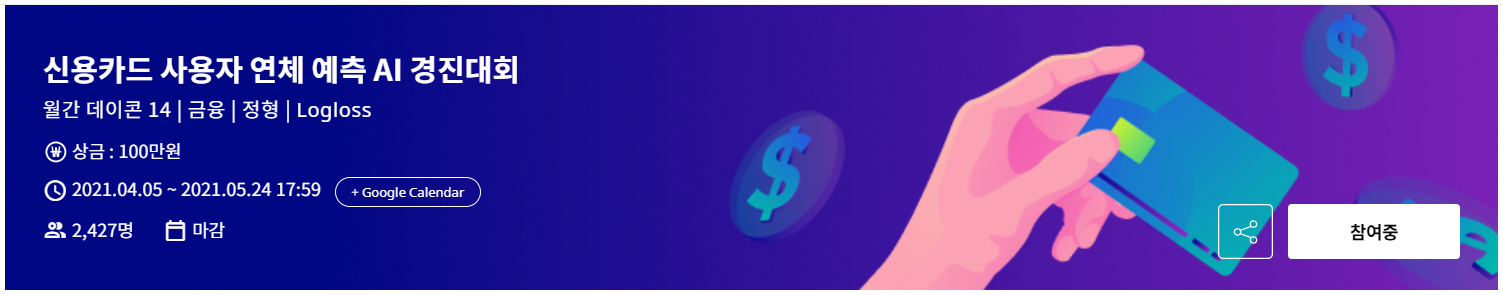



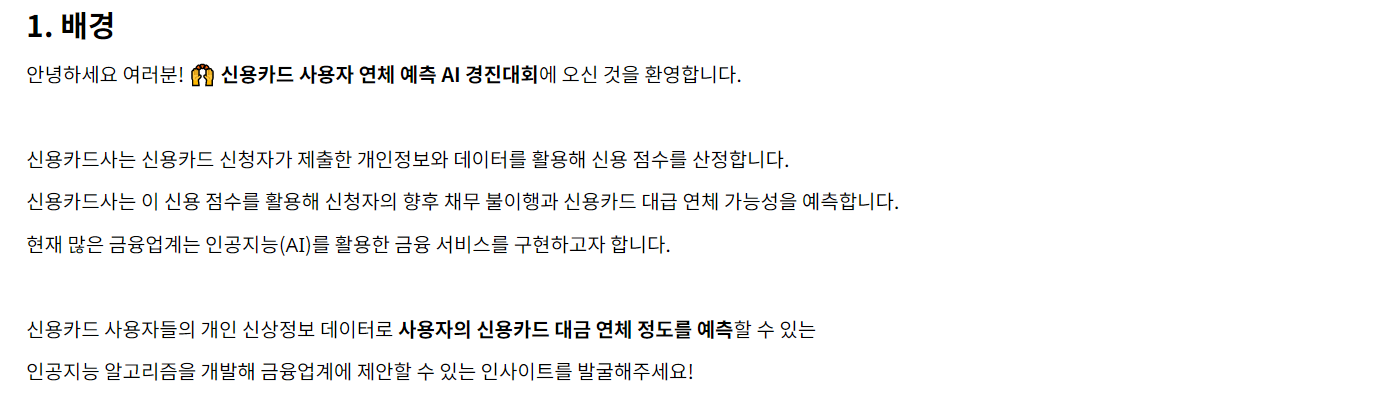

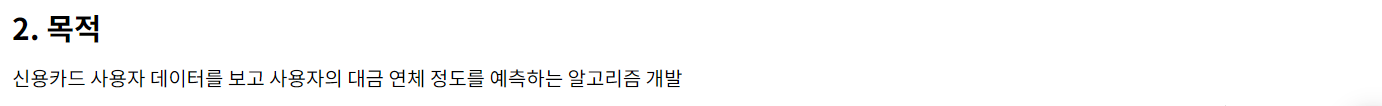

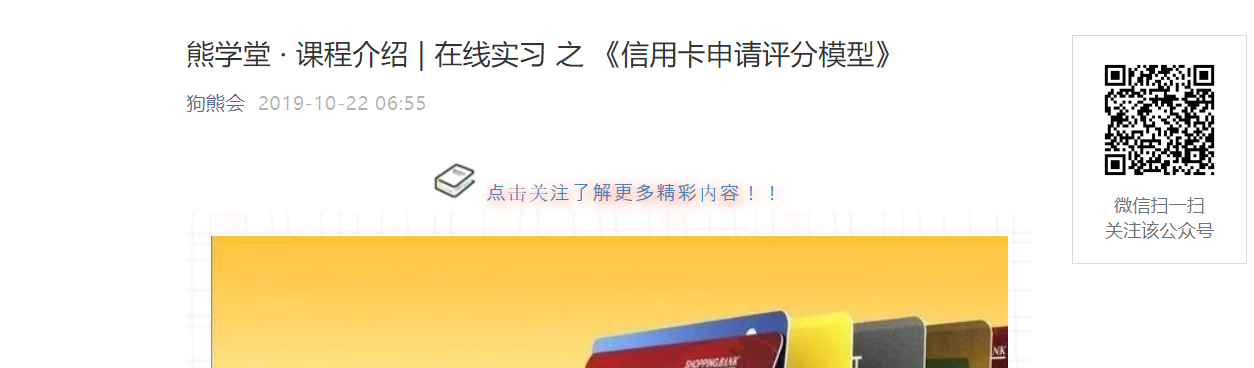

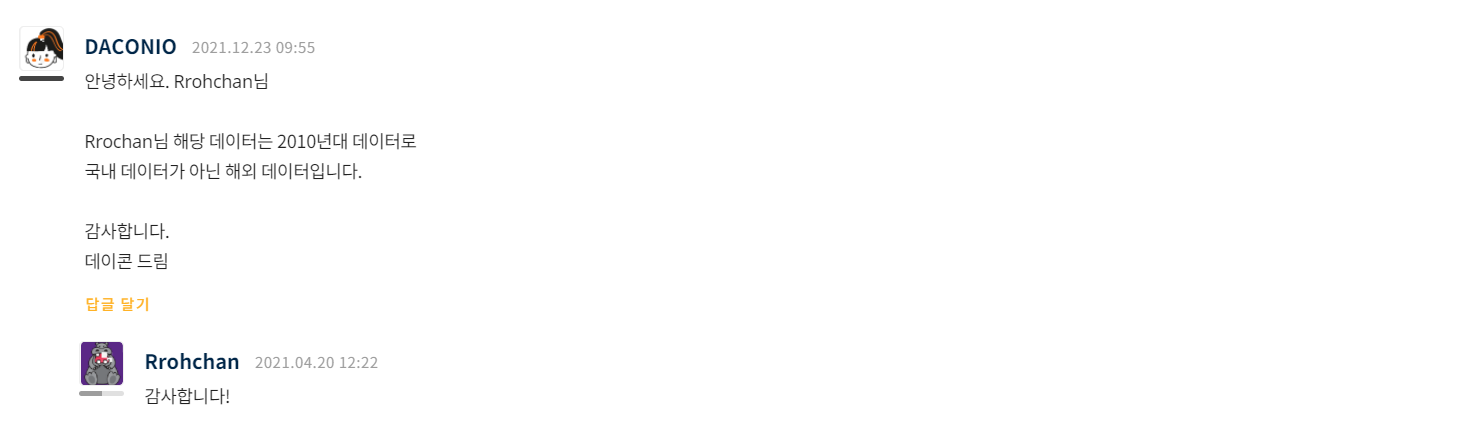

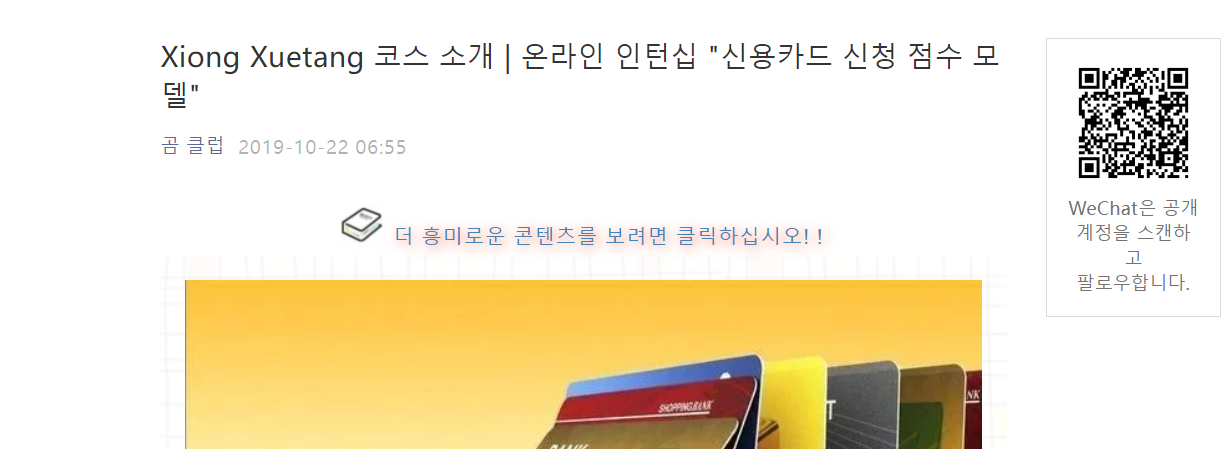

# 머신러닝 프로젝트 - 신용카드 사용자 연체 예측 AI

## 1. 프로젝트 배경


### 선정이유

- 데이콘에 있는 정형 데이터 문제들 중 상대적으로 공유 코드가 많은 주제를 선정  
- 신용카드업: 상대적으로 이해하기 쉬운 도메인
- 신용도: 상대적으로 이해하기 쉬운 종속변수

### 아쉬운 점
- 데이터에 제공되는 기본값이 없어서 개별 사용자를 식별하기 어려움
- 신용도를 예측/분류하기에는 데이터의 폭이 전반적으로 부족
- 중국의 데이터라서 다른 데이터를 연동하는 것이 불가능

## 2. 프로젝트 목적

* 데이터 분석 및 전처리와 머신러닝을 사용하여 신용카드 사용자 데이터를 분석하여 사용자의 신용카드 대금 연체 정도를 예측

## 3. 코드 시작 
## 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 패키지 설치

In [ ]:
# Catboost & Encoder
!pip install catboost
!pip install category_encoders

     |████████████████████████████████| 76.1 MB 1.1 MB/s 
     |████████████████████████████████| 82 kB 409 kB/s 


## 라이브러리 구성

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
%matplotlib inline

mpl.rc('font', family = 'Malgun Gothic')
mpl.rc('axes', unicode_minus = False)
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

## 데이터 불러오기

In [ ]:
repository = '/content/drive/MyDrive/'
train = pd.read_csv(repository + 'train.csv')
test = pd.read_csv(repository + 'test.csv')

In [ ]:
# 불러온 데이터 직접 확인
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
# 훈련 데이터 세트는 총 26,457 개 행의 데이터, 신용도 종속변수 열을 포함한 20개의 열 속성 데이터
print(train.shape)

(26457, 20)


In [ ]:
# 테스트 데이터 세트는 총 10,000 개 행의 데이터, 종속변수를 제외한 19개의 열 속성 데이터
print(test.shape)
test.head()

(10000, 19)


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [ ]:
# 데이터 타입 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          10000 non-null  int64  
 1   gender         10000 non-null  object 
 2   car            10000 non-null  object 
 3   reality        10000 non-null  object 
 4   child_num      10000 non-null  int64  
 5   income_total   10000 non-null  float64
 6   income_type    10000 non-null  object 
 7   edu_type       10000 non-null  object 
 8   family_type    10000 non-null  object 
 9   house_type     10000 non-null  object 
 10  DAYS_BIRTH     10000 non-null  int64  
 11  DAYS_EMPLOYED  10000 non-null  int64  
 12  FLAG_MOBIL     10000 non-null  int64  
 13  work_phone     10000 non-null  int64  
 14  phone          10000 non-null  int64  
 15  email          10000 non-null  int64  
 16  occyp_type     6848 non-null   object 
 17  family_size    10000 non-null  float64
 18  begin_m

# 데이처 전처리 Preprocessing & Feature Engineering


### 결측치 처리

In [ ]:
# 26457 개의 훈련 데이터 중 8171 개의 직업의 데이터가 없음
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
# 10000 개의 테스트 데이터 중 8171 개의 직업의 데이터가 없음
test.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

#### 1. 의미없는 변수 제거
- index 제거 : 데이터 순서와 데이터 자체의 연관 무
- FLAG_MOBIL 삭제 : 모든 값이 1로 동일

In [ ]:
train.groupby(['FLAG_MOBIL'])['credit'].count()

FLAG_MOBIL
1    26457
Name: credit, dtype: int64

#### 2. DAYS_EMPLOYED
- 취업이 된지 몇일지 되었는지
- 데이콘 주최측의 데이터 변수 설명에서 음수 값이 중요하며, 양수 값은 무의미한 값이라 하여 
양수는 0으로 변경

#### 3. DAYS_BIRTH, begin_month, DAYS_EMPLOYED
- 음수로 저장된 변수 값 -> 모두 양수로 변환

In [ ]:
for df in [train,test]:
  # 0. 결측치 대체
  df.fillna('NaN', inplace=True) 

  # 1. 무의미한 컬럼 삭제
  df.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

  # 2. 무의미한 양수 값 0으로 변경
  df['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

  # 3. 음수로 표기된 값들을 모두 양수로 바꾸기
  feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
  for feat in feats:
    df[feat]=np.abs(df[feat])

#### 4. 파생변수 - 나이 관련 : 
* AGE : 만나이
* AGE_col : 나이의 앞자리 수, (예) 22세 -> 20대 -> 2
* AGE_months = 나이를 만 개월 수로 환산 
* AGE_weeks = 나이를 만으로 몇 주인지 환산


In [ ]:
for df in [train, test]:

  # 태어난 후 일수 // 365 
  df['Age'] = np.abs(df['DAYS_BIRTH']) // 365

  # 나이 앞자리 수
  df['Age_col'] = 0
  df.loc[df['Age']<30, 'Age_col'] = 2 #20대
  df.loc[(df['Age']>=30) & (df['Age']<40), 'Age_col'] = 3 #30대
  df.loc[(df['Age']>=40) & (df['Age']<50), 'Age_col'] = 4 #40대
  df.loc[(df['Age']>=50) & (df['Age']<60), 'Age_col'] = 5 #50대
  df.loc[df['Age']>=60, 'Age_col'] = 6 #60대 

  # DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생한지 n주차)
  df['Age'] = df['DAYS_BIRTH'] // 365
  df['AGE_months'] = df['DAYS_BIRTH'] // 30
  df['AGE_weeks'] = df['DAYS_BIRTH'] // 7

### 5. 파생변수 - 가족 인원 수 관련 : child_num, family_size

* family_size : 가족 수가 5 이상이면 5 로 처리
* child_num : 자녀 수가 3 이상이면 3 으로 처리
* child_exist : 자녀 존재 여부, 자녀 수가 없으면 0, 있으면 1 
* no_parent : 부모 수 (number of parents), 가족 수 - 자녀 수
* single_person_households : 1인 가족인지 사실여부, 1인 가족이면 1, 아니면 0
* 결측치 처리 : 가족 수에서 자녀 수를 뺀 수가 0 또는 미만이면, 가족 인원수를 child_num + 2로 대체

In [ ]:
for df in [train,test]:
  
  df['family_size'][df['family_size'] >= 5] = 5
  df['child_num'][df['child_num'] >= 3] = 3
  df['child_exist'] = df['child_num'].map(lambda x: 0 if x == 0 else 1)
  df['family_size'][df['family_size'] - df['child_num'] <= 0] = df['child_num'] + 2
  df['no_parent'] = df['family_size'] - df['child_num']
  df['single_person_households'] = df['family_size'].map(lambda x: 1 if x == 1 else 0)

### 6. 파생변수 - 고용 관련 변수 생성
* 취업 및 무취업 기간 년, 월, 주로 환산

In [ ]:
for df in [train,test]:

    # 태어난 후부터 계산한 무취업 일수
    df['DAYS_UNEMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['UNEMPLOYED_years'] = df['DAYS_UNEMPLOYED'] // 365
    df['UNEMPLOYED_months'] = df['DAYS_UNEMPLOYED'] // 30 
    df['UNEMPLOYED_weeks'] = df['DAYS_UNEMPLOYED'] // 7
    
    # 고용 관련 변수 생성(취업 기간 년, 월, 주로 환산)
    df['EMPLOYED_years'] = df['DAYS_EMPLOYED'] // 365
    df['EMPLOYED_months'] = df['DAYS_EMPLOYED'] // 30
    df['EMPLOYED_weeks'] = df['DAYS_EMPLOYED'] // 7

    # 경력이 없고 직업군이 none인 사람은 no_work로 대체
    df.loc[(df['DAYS_EMPLOYED'] == 0) & (df['occyp_type'] == 'NaN'), 'occyp_type'] = 'no_work'

### 7. 파생변수 - 연봉 관련


In [ ]:
for df in [train,test]:

    # 한 사람/회원이 대략적으로 평생 번 금액
    df['income_whole_life'] = df['income_total'] * df['EMPLOYED_years']

    # salary 월급
    df['salary'] = df['income_total'] // 12

    # 가족 1인당 연간 사용 가능 한도 금액 = 연간 소득 / 가족 인원수
    df['income_per_person'] = df['income_total'] / df['family_size']
    
    # 가족 1인당 월간 사용 가능 한도 금액 = 월급 / 가족 인원수
    df['income_pp_month'] = df['salary'] / df['family_size']

### 8. 파생변수 - 회원 각각의 고유한 번호 생성 (ID)

In [ ]:
for df in [train,test]:
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악
    
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

    # feature importance 가 가장 높게 나온 begin_month 와 ID 를 결합하여 추가로 변수 생성
    df['ID_2'] = df['begin_month'].astype(str) + '_' + df['ID'].astype(str)

    # 기본적인 정보들을 더한 코드 생성 : 성별 , 자동차 소유여부, 부동산 소유여부, 이메일 입력여부
    df['GCRE_code'] = (
        df["gender"].astype(str)
        + "_"
        + df["car"].astype(str)
        + "_"
        + df["reality"].astype(str)
        + "_"
        + df["email"].astype(str)
    )

    delete = ["car", "reality", "email" ]
    df.drop(delete, axis=1, inplace=True)


In [ ]:
train.head()

,gender,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,occyp_type,family_size,begin_month,credit,Age,Age_col,AGE_months,AGE_weeks,child_exist,no_parent,single_person_households,DAYS_UNEMPLOYED,UNEMPLOYED_years,UNEMPLOYED_months,UNEMPLOYED_weeks,EMPLOYED_years,EMPLOYED_months,EMPLOYED_weeks,income_whole_life,salary,income_per_person,income_pp_month,ID,GCRE_code
0,F,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,NaN,2.0,6.0,1.0,38,3,463,1985,0,2.0,0,9190,25,306,1312,12,156,672,2430000.0,16875.0,101250.0,8437.5,6.0_0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Comm...,F_N_N_0
1,F,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,0,0,Laborers,3.0,5.0,1.0,31,3,379,1625,1,2.0,0,9840,26,328,1405,4,51,220,990000.0,20625.0,82500.0,6875.0,5.0_1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Comm...,F_N_Y_1
2,M,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,0,1,Managers,2.0,22.0,2.0,52,5,636,2726,0,2.0,0,14653,40,488,2093,12,147,633,5400000.0,37500.0,225000.0,18750.0,22.0_0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Wor...,M_Y_Y_0
3,F,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,0,1,Sales staff,2.0,37.0,0.0,41,4,502,2155,0,2.0,0,12996,35,433,1856,5,69,298,1012500.0,16875.0,101250.0,8437.5,37.0_0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Com...,F_N_Y_0
4,F,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,0,0,Managers,2.0,26.0,2.0,41,4,501,2148,0,2.0,0,12932,35,431,1847,5,70,300,787500.0,13125.0,78750.0,6562.5,26.0_0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_Sta...,F_Y_Y_0


In [ ]:
print(train.shape)

(26457, 35)


In [ ]:
print(test.shape)

(10000, 34)


# 데이터 시각화

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

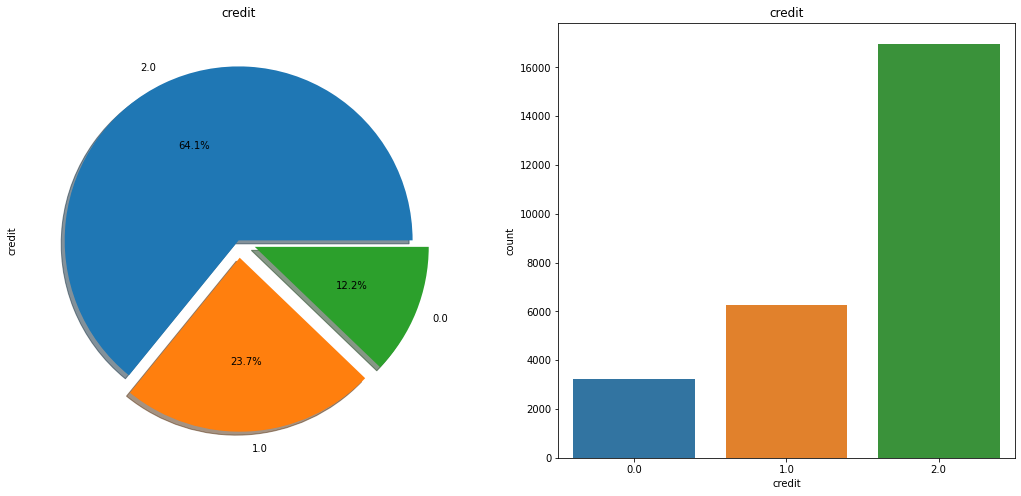

In [ ]:
#credit비율
#신용도가 낮은 사용자의 비율이 많다 (credit = 2)
# 0 가장 높은 신용도
# 1 중간 신용도
# 2 가장 낮은 신용도

f, ax = plt.subplots(1, 2, figsize=(18,8))
train['credit'].value_counts().plot.pie(explode=[0,0.1, 0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('credit')
ax[0].set_ylabel('credit')
sns.countplot('credit',data=train,ax=ax[1])
ax[1].set_title('credit')
plt.show()

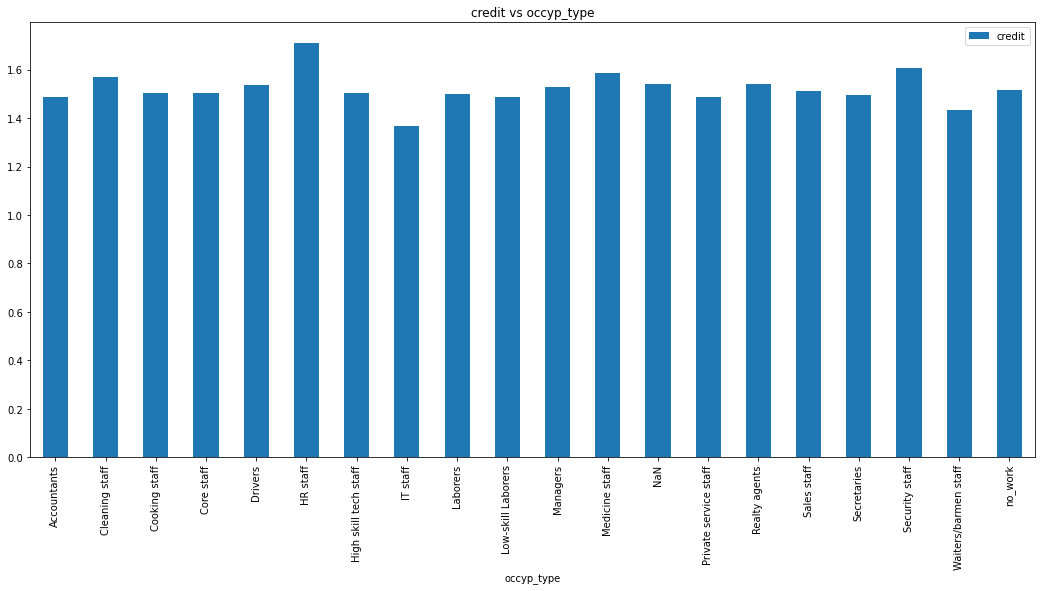

In [ ]:
f,ax = plt.subplots(1,1,figsize=(18,8))
train[['occyp_type','credit']].groupby(['occyp_type']).mean().plot.bar(ax=ax)
plt.title('credit vs occyp_type')
plt.show()

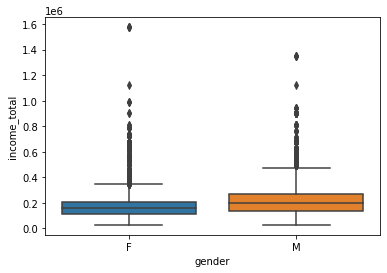

In [ ]:
# 성별에 따른 income_total

sns.boxplot(data=train, x='gender', y='income_total')

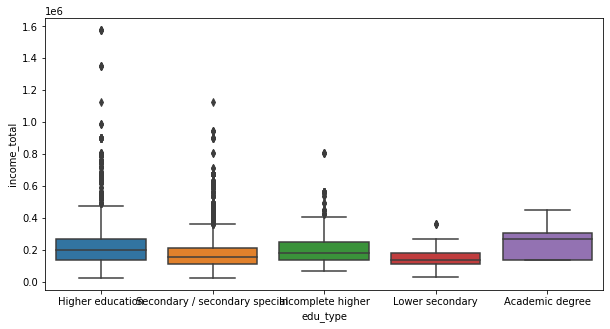

In [ ]:
#edu_type에 따른 income_total

# Lower secondary 중학교 졸업
# Secondary / secondary specialist 고등학교 졸업
# Incomplete higher 대학 중퇴
# Higher education 대학 졸업
# Academic degree 석사 또는 박사 학위 취득

plt.figure(figsize=[10,5])
sns.boxplot(data=train, x='edu_type', y='income_total')

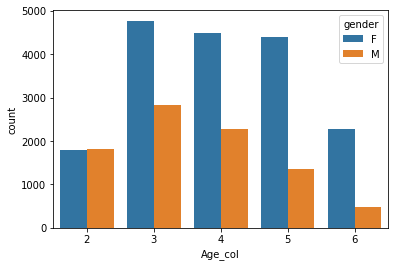

In [ ]:
#연령대 별 count 확인 (hue=성별)

sns.countplot(data=train, x='Age_col', hue='gender')

#**Scaling & Encoding**

# 1. Log Scale

### 왼쪽으로 데이터가 쏠린 현상을 보였던 income_total 관련 데이터를 로그변환하여 정규화를 해주고, 분석을 더 쉽게 하였다. 

(array([1.6212e+04, 8.3300e+03, 1.5300e+03, 2.0600e+02, 1.2100e+02,
        4.4000e+01, 3.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00]),
 array([  27000.,  181800.,  336600.,  491400.,  646200.,  801000.,
         955800., 1110600., 1265400., 1420200., 1575000.]),
 <a list of 10 Patch objects>)

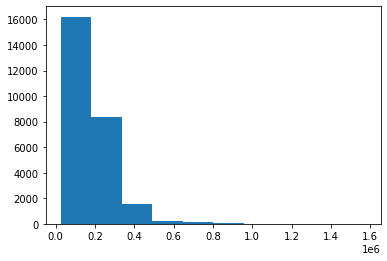

In [ ]:
%matplotlib inline
plt.hist(train['income_total']) 

# 연봉 그래프 : 
# 연봉 데이터가 왼쪽으로 치우쳐져 있는 것을 보실 수 있습니다. 

In [ ]:
for df in [train,test]:
  
    df['income_total'] = np.log1p(df['income_total'])
    df['income_whole_life'] = np.log1p(df['income_whole_life'])
    df['income_per_person'] = np.log1p(df['income_per_person'])
    df['income_pp_month'] = np.log1p(df['income_pp_month'])
    df['salary'] = np.log1p(df['salary'])

(array([  84.,  341., 2788., 7265., 7716., 5505., 2362.,  308.,   77.,
          11.]),
 array([10.20362918, 10.61024291, 11.01685664, 11.42347037, 11.83008409,
        12.23669782, 12.64331155, 13.04992528, 13.45653901, 13.86315274,
        14.26976647]),
 <a list of 10 Patch objects>)

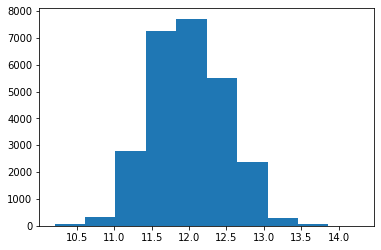

In [ ]:
plt.hist(train['income_total']) 

# 로그변환 후 연봉 그래프 :
# 로그변환 전보다 데이터 그래프가 중심부로 이동하고, 조금 더 정규화된 모습을 보실 수 있습니다.

## 왜 다른 Scaling 은 진행하지 않았나요?

### 시도한 Scaler 종류 : 
- StandardScaler() : 특정 특성 데이터들의 평균을 0, 분산을 1로 스케일링하여, 정규분포로 만든다. 이상치에 매우 민감하며 최솟값과 최댓값의 크기를 제한하지 않기 때문에 어떤 알고리즘에서는 문제가 발생할 수 있다. 회귀보다는 분류에 유용합니다.
- MinMaxScaler() : 특성들의 최솟값을 0, 최댓값을 1로 변환시켜 모든 특성들이 0과 1 사이에 위치하게 만든다. (이상치에 민감하다.)
- RobustScaler() : 중앙값과 사분위 값을 사용하여 중앙값을 0으로 변환시킨다. 이상치의 영향을 최소화 시킨다. (데이터 값 - 중앙값 / 3분위 수 – 1분위 수) 

## 다양한 Scaling을 시도해 보았으나, 
**정수인 값만 모델 계산에 사용하는 Catboost 모델을 메인으로 사용하기에 Scaling 을 하지 않았습니다.**



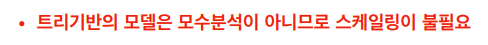

## 2. 수치형, 범주형 데이터 분류 및 Encoding
#### 머신 러닝 모델은 입력 변수가 수치형 데이터 이어야만 하기에, 범주형과 수치형 데이터 분류 후 범주형 데이터를 수치형 데이터로 바꿔 주는 encoding 을 하였습니다.

#### 머신 러닝에 많이 사용되는 데이터 두 종류 :

>수치형 데이터 Numerical Data : 나이, 몸무게, 키

>범주형 데이터 Categorical Data : 혈액형, 성별


In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  26
Number of Categorical features:  8


In [ ]:
numerical_feats

In [ ]:
categorical_feats

## OrdinalEncoder

* 카테고리 변수는 ordinal_encoder 변환

In [ ]:
# Encoding 을 수기로 직접 시도 - 학력의 순서에 맞게 가중치를 두고, 숫자를 지정하기위해서 

edu_dict = {'Lower secondary':1,
  'Secondary / secondary special':2,
  'Incomplete higher':3,
  'Higher education':4,
  'Academic degree':5}

train['edu_type'].replace(edu_dict,inplace=True)
test['edu_type'].replace(edu_dict,inplace=True)

In [ ]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

# 캣부스트 알고리즘 사용을 위해 모든 특성을 정수로 변환
for df in [test,train]:
  for feat in df.columns:
    df[df.columns] = df[df.columns].astype(int)

### 왜 One-Hot Encoding 원핫 인코딩을 사용하지 않았나요?

In [ ]:
# 특정 항목만 One-hot encoding
# train = pd.get_dummies(data = train, columns = ['income_type', 'family_type', 'house_type', 'occyp_type'])
# train

 
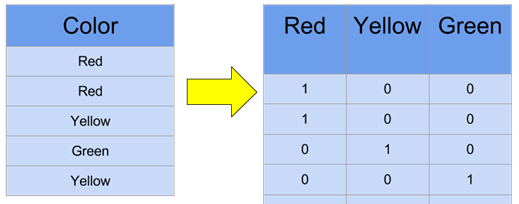


출처: https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding



### One-Hot Encoding 사용 시 장점 : 
- 숫자를 이용한 라벨 인코딩을 하면, 
성별 또는 직업과 같은 범주형 데이터에 특정 데이터의 값이 더 크고 더 작다는 개념이 생기기에,
> (예) 직업 간에 크고 작은 관계가 형성된다.

 머신러닝이 엉뚱한 관계를 학습하고 예측을 방해하는 것을 방지할 수 있다.

### One-Hot Encoding 사용 시 단점 :

- 속성들의 카테고리수가 너무 많아, 불필요하게 feature 수가 너무 많이 증가해서 결과에 안좋은 영향이 있을 수 있기에 Ordinal Encoding 을 선택하였습니다.

>(특히 직업 종류는 19가지 -> 원핫인코딩 시, 19개의 컬럼 추가됨) 

  



In [ ]:
train.head()

,gender,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,occyp_type,family_size,begin_month,credit,Age,Age_col,AGE_months,AGE_weeks,child_exist,no_parent,single_person_households,DAYS_UNEMPLOYED,UNEMPLOYED_years,UNEMPLOYED_months,UNEMPLOYED_weeks,EMPLOYED_years,EMPLOYED_months,EMPLOYED_weeks,income_whole_life,salary,income_per_person,income_pp_month,ID,GCRE_code
0,1,0,12,1,4,1,1,13899,4709,0,0,1,2,6,1,38,3,463,1985,0,2,0,9190,25,306,1312,12,156,672,14,9,11,9,1,1
1,1,1,12,1,2,2,2,11380,1540,0,0,2,3,5,1,31,3,379,1625,1,2,0,9840,26,328,1405,4,51,220,13,9,11,8,2,2
2,2,0,13,2,4,1,2,19087,4434,0,1,3,2,22,2,52,5,636,2726,0,2,0,14653,40,488,2093,12,147,633,15,10,12,9,3,3
3,1,0,12,1,2,1,2,15088,2092,0,1,4,2,37,0,41,4,502,2155,0,2,0,12996,35,433,1856,5,69,298,13,9,11,9,4,4
4,1,0,11,3,4,1,2,15037,2105,0,0,3,2,26,2,41,4,501,2148,0,2,0,12932,35,431,1847,5,70,300,13,9,11,8,5,5


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   gender                    26457 non-null  int64
 1   child_num                 26457 non-null  int64
 2   income_total              26457 non-null  int64
 3   income_type               26457 non-null  int64
 4   edu_type                  26457 non-null  int64
 5   family_type               26457 non-null  int64
 6   house_type                26457 non-null  int64
 7   DAYS_BIRTH                26457 non-null  int64
 8   DAYS_EMPLOYED             26457 non-null  int64
 9   work_phone                26457 non-null  int64
 10  phone                     26457 non-null  int64
 11  occyp_type                26457 non-null  int64
 12  family_size               26457 non-null  int64
 13  begin_month               26457 non-null  int64
 14  credit                    26457 non-nu

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   gender                    10000 non-null  int64
 1   child_num                 10000 non-null  int64
 2   income_total              10000 non-null  int64
 3   income_type               10000 non-null  int64
 4   edu_type                  10000 non-null  int64
 5   family_type               10000 non-null  int64
 6   house_type                10000 non-null  int64
 7   DAYS_BIRTH                10000 non-null  int64
 8   DAYS_EMPLOYED             10000 non-null  int64
 9   work_phone                10000 non-null  int64
 10  phone                     10000 non-null  int64
 11  occyp_type                10000 non-null  int64
 12  family_size               10000 non-null  int64
 13  begin_month               10000 non-null  int64
 14  Age                       10000 non-nul

# Modeling - Pycaret

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.classification import *

In [ ]:
model = setup(
    data = train,
    target = 'credit'
)

,Description,Value
0,session_id,4024
1,Target,credit
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(26457, 36)"
5,Missing Values,False
6,Numeric Features,29
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
compare_models(exclude = None, include = None, fold = 10, round = 4, sort = 'Accuracy',
               n_select = 1, budget_time = 0, turbo = True, verbose = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7051,0.7230,0.4599,0.6877,0.6475,0.2858,0.3419,15.927
lightgbm,Light Gradient Boosting Machine,0.7046,0.7190,0.4439,0.7025,0.6364,0.2644,0.3395,0.836
rf,Random Forest Classifier,0.7000,0.7494,0.5368,0.6776,0.6826,0.3682,0.3753,2.944
gbc,Gradient Boosting Classifier,0.6933,0.6683,0.4121,0.6768,0.6084,0.2123,0.3046,7.917
ada,Ada Boost Classifier,0.6911,0.6308,0.4059,0.6615,0.6022,0.2001,0.2980,0.713
et,Extra Trees Classifier,0.6832,0.7149,0.5271,0.6618,0.6675,0.3378,0.3432,2.113
lr,Logistic Regression,0.6451,0.6148,0.3397,0.5365,0.5140,0.0198,0.0680,3.496
lda,Linear Discriminant Analysis,0.6451,0.6154,0.3404,0.5338,0.5152,0.0216,0.0693,0.077
ridge,Ridge Classifier,0.6439,0.0000,0.3375,0.5309,0.5101,0.0127,0.0513,0.042
dummy,Dummy Classifier,0.6423,0.5000,0.3333,0.4125,0.5024,0.0000,0.0000,0.031


## 의사 결정 트리 Decision Tree

In [ ]:
# DecisionTree

# 훈련 데이터 세트를 복사 
X = train.copy()
X.drop(['credit'], axis = 1, inplace = True)
y= train['credit']
X

,gender,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,occyp_type,family_size,begin_month,Age,Age_col,AGE_months,AGE_weeks,child_exist,no_parent,single_person_households,DAYS_UNEMPLOYED,UNEMPLOYED_years,UNEMPLOYED_months,UNEMPLOYED_weeks,EMPLOYED_years,EMPLOYED_months,EMPLOYED_weeks,income_whole_life,salary,income_per_person,income_pp_month,ID,GCRE_code,no_credit
0,1,0,12,1,4,1,1,13899,4709,0,0,1,2,6,38,3,463,1985,0,2,0,9190,25,306,1312,12,156,672,14,9,11,9,1,1,1
1,1,1,12,1,2,2,2,11380,1540,0,0,2,3,5,31,3,379,1625,1,2,0,9840,26,328,1405,4,51,220,13,9,11,8,2,2,2
2,2,0,13,2,4,1,2,19087,4434,0,1,3,2,22,52,5,636,2726,0,2,0,14653,40,488,2093,12,147,633,15,10,12,9,3,3,2
3,1,0,12,1,2,1,2,15088,2092,0,1,4,2,37,41,4,502,2155,0,2,0,12996,35,433,1856,5,69,298,13,9,11,9,4,4,1
4,1,0,11,3,4,1,2,15037,2105,0,0,3,2,26,41,4,501,2148,0,2,0,12932,35,431,1847,5,70,300,13,9,11,8,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,1,2,12,3,2,1,2,12079,1984,0,0,6,4,2,33,3,402,1725,1,2,0,10095,27,336,1442,5,66,283,13,9,10,8,24098,1,1
26453,1,1,12,2,4,3,2,15291,2475,0,0,1,2,47,41,4,509,2184,1,1,0,12816,35,427,1830,6,82,353,13,9,11,8,24099,4,1
26454,1,0,12,2,2,2,3,10082,2015,0,0,6,2,25,27,2,336,1440,0,2,0,8067,22,268,1152,5,67,287,14,10,11,9,24100,14,1
26455,2,0,12,2,3,4,2,10145,107,0,0,2,1,59,27,2,338,1449,0,1,1,10038,27,334,1434,0,3,15,0,9,12,9,24101,9,1


In [ ]:
# 훈련 데이터를 train set, test set 두가지로 나누기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

In [ ]:
# 필요한 라이브러리 호출
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from IPython.display import Image
import pydotplus
import os

In [ ]:
# 의사 결정 트리를 만들 객체 생성
dt_clf = DecisionTreeClassifier()
# 트리를 데이터에 맞추기
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
# 만든 의사 결정 트리 모델로 테스트 세트의 값을 예측
pred = dt_clf.predict(X_test)

# 실제 정답 값과 예측 값을 비교한 결과 
from sklearn.metrics import accuracy_score
print('정확도:', accuracy_score(y_test, pred))

정확도: 0.5842781557067271


## Random Forest 알고리즘

In [ ]:
# RandomForest 가 Decision Tree 보다 높은 정확도를 보입니다.

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('정확도:', accuracy)

정확도: 0.7078609221466364


## Grid Search CV 를 통한 Random Forest 파라미터 튜닝

In [ ]:
# Random Forest 성능 향상을 위한 파라미터 튜닝

from sklearn.model_selection import GridSearchCV

# 파라미터 
params = {
    'n_estimators' : [100, 200, 300, 400],
    'max_depth' : [8, 10, 15, 20],
    'min_samples_leaf' : [4, 6, 8],
    'min_samples_split' : [4, 6, 8]
} 

In [ ]:
rf_clf = RandomForestClassifier(n_jobs = 10)
rf_clf

RandomForestClassifier(n_jobs=10)

In [ ]:
grid_cv = GridSearchCV(rf_clf, param_grid = params, n_jobs = 3)
grid_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=10), n_jobs=3,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [8, 12, 18],
                         'min_samples_split': [8, 16, 20],
                         'n_estimators': [100, 200, 300]})

In [ ]:
pred = grid_cv.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('정확도: {}'.format(accuracy))

정확도: 0.6857520786092215


In [ ]:
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도:{0: .4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 200}
최고 예측 정확도: 0.6943


In [ ]:
# 컬럼 중요도 계산

df_importance_values = rf_clf1.feature_importances_
df_importance_values

array([0.00550545, 0.00530842, 0.00803179, 0.00667099, 0.00873308,
       0.00916067, 0.00536001, 0.0387339 , 0.03702752, 0.00420426,
       0.00495229, 0.02161289, 0.00672988, 0.46942645, 0.01511422,
       0.00277296, 0.03074516, 0.03718581, 0.00356464, 0.00297741,
       0.00263853, 0.03569429, 0.01469963, 0.02903598, 0.03441041,
       0.01127166, 0.0272824 , 0.03084957, 0.0072851 , 0.00632642,
       0.0071778 , 0.00860377, 0.03301876, 0.01994508, 0.0079428 ])

In [ ]:
feature_importance = pd.Series(data = df_importance_values, index = X_test.columns)
feature_importance_top10 = feature_importance.sort_values(ascending = False).head(10)

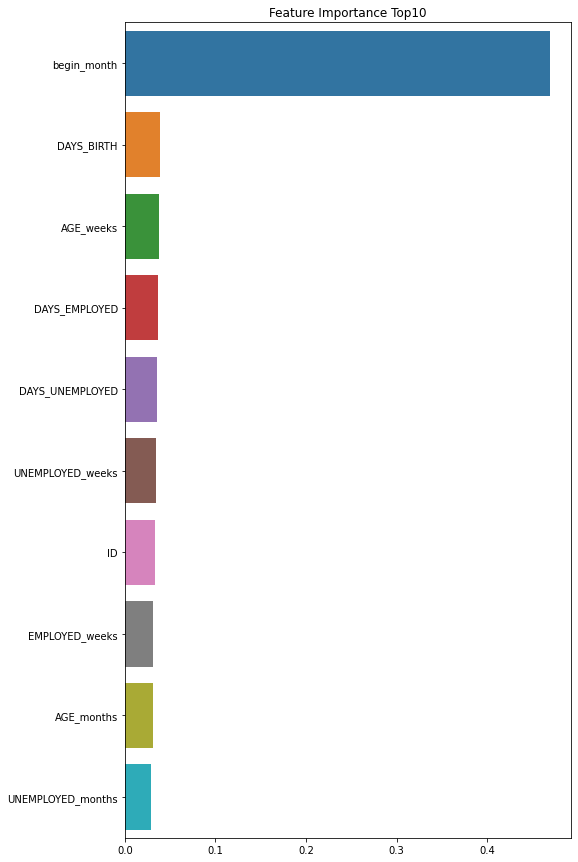

In [ ]:
# 시각화
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (8, 15))
plt.title('Feature Importance Top10')
sns.barplot(x = feature_importance_top10, y = feature_importance_top10.index)
plt.show()

## XGBoost

In [ ]:
# XGBoost
import xgboost as xgb
from xgboost import plot_importance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

In [ ]:
from xgboost import XGBClassifier
xgboost = XGBClassifier()
xgboost

XGBClassifier()

In [ ]:
xgboost.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [ ]:
pred = xgboost.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('정확도:', accuracy)

정확도: 0.6846182917611489


In [ ]:
# RandomForest가 정확도 가장 높음.

xgb_clf = XGBClassifier(n_estimators = 10)
xgb_clf

XGBClassifier(n_estimators=10)

In [ ]:
# XGBoost의 파라미터 리스트
params = {'max_depth' : [5, 7, 9],
          'min_child_weight' : [1, 3, 5, 7],
          'colsample_bytree' : [0.1, 0.5, 0.75, 1.0],
          'learning_rate' : [0.001, 0.01, 0.1, 0.2]
          }

In [ ]:
gridcv = GridSearchCV(xgb_clf, param_grid = params)
gridcv.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(n_estimators=10),
             param_grid={'colsample_bytree': [0.1, 0.5, 0.75, 1.0],
                         'learning_rate': [0.001, 0.01, 0.1, 0.2],
                         'max_depth': [5, 7, 9],
                         'min_child_weight': [1, 3, 5, 7]})

In [ ]:
print('GridSearchCV 최적의 파라미터:', gridcv.best_params_)

GridSearchCV 최적의 파라미터: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1}


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# precision(예측데이터의 정밀도) 
precision_score(y_test, pred, pos_label = 'positive', average = 'micro')

0.6899092970521542

In [ ]:
# gridcv에 설정된 모든 경우의 수에 대해서 (최소의 cost를 갖는) XGBoost 객체 리턴
gridcv.best_estimator_

XGBClassifier(colsample_bytree=0.5, learning_rate=0.2, max_depth=9,
              n_estimators=10, objective='multi:softprob')

## Modeling - LightGBM

>장점 : 
>학습하는데 걸리는 시간이 적고, 속도가 빠릅니다. 그리고 메모리 사용량이 상대적으로 적은 편입니다. 
카테고리형 feature들의 자동 변환과 최적 분할이 장점입니다.


>단점 : 
>작은 데이터 셋을 사용할 경우 과적합 가능성이 큽니다. 
일반적으로 작은 데이터 셋이라고 하면 10,000개 이하의 데이터를 말한다고 합니다.


In [ ]:
# LightGBM
#!pip install lightgbm

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = train.copy()
X.pop('credit')
y = train['credit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

In [ ]:
import lightgbm as lgb
import time
from sklearn.metrics import accuracy_score

start = time.time()
lgb_dtrain = lgb.Dataset(data = X_train, label = y_train)

lgb_param = {
            # 트리의 깊이
              'max_depth' : 10, 
             # 학습률 default = 0.1
             'learning_rate' : 0.01,
             # 반복 수행하는 트리 갯수
             'n_estimators' : 100, 
             'objective' : 'multiclass',
             'num_class' : len(set(y_train)) + 1}
# 파라미터 추가, label - num_class보다 1 커야 함.

lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain)
lgb_model_predict = np.argmax(lgb_model.predict(X_test), axis = 1)

print('Accuracy: %.2f' % (accuracy_score(y_test, lgb_model_predict) * 100), '%')
print('Time: %.2f' % (time.time() - start), 'seconds')

Accuracy: 68.41 %
Time: 2.12 seconds


In [ ]:
# feature importance
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_names' : feature_names, 'feature_importance' : feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by = ['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

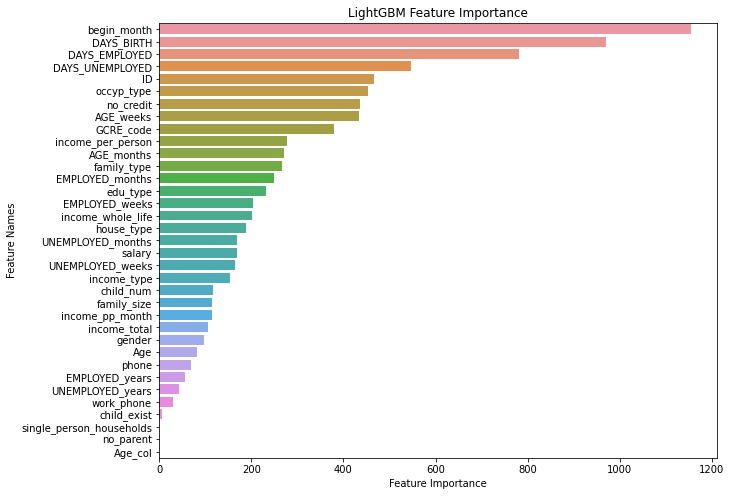

In [ ]:
plot_feature_importance(lgb_model.feature_importance(), X_test.columns, 'LightGBM')

# Modeling - Catboost & StratifiedKFold



### k-겹 교차 검증 StratifiedKFold 이란?



1.   예를 들어 k=5, 데이터가 총 1000개가 있다면 이 데이터를 200개씩 5개의 셋으로 나눕니다. 
2.   저 첫번째 세트를 test set 으로 정하고, 나머지 4개를 training set으로 사용합니다.
3. 그다음 차례대로 두 번째 데이터 셋을 test set으로 사용하고, 나머지 4개를 training set으로 사용합니다. 
4.  그렇게 차례대로 5개의 데이터 셋을 test set 으로 각각 사용했을 때의 5개의 성능의 평균치를 구하여 이 평균을 모델 성능으로 보는 겁니다. 


모델의 성능을 여러 번 약간씩 다른 데이터로 검증하여 평균치를 구하기에 신뢰도가 올라갑니다.

가장 일반적으로 사용하는 k의 값은 5입니다. 


* 데이터가 많을수록 우연히 어느 test set에서만 성능이 다르게 나올 확률이 적기 때문에 작은 k를 사용해도 됩니다. *
 



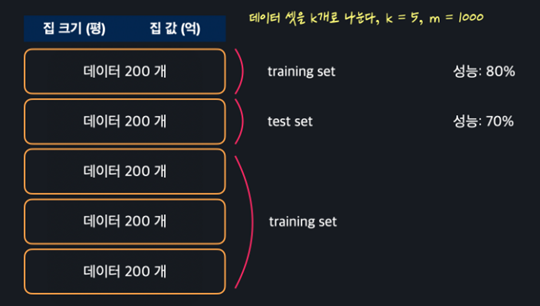

출처 : https://www.codeit.kr/learn/courses/machine-learning/3334

## Catboost Model
**범주형 데이터가 많을 때 강한 모델인 캣부스트를 사용하였습니다.**

기존의 Boosting 기법은 실제 값과 실제 값의 평균의 차인 잔차를 구하여 잔차를 학습하도록 모델이 만들어집니다. 
만든 모델로 예측을 하여, 예측 값에 learning_rate 를 곱하여 실제 예측 값을 점점 업데이트 한다. 

기존의 Boosting Model 의 두 가지 문제 :
* 느린 학습 속도
* 과대적합
* (Bagging 은 여러 트리들이 병렬적으로 모델을 학습하고, 
Boosting 은 순차적으로 모델을 학습하기에 느릴 수 밖에 없다.)

**새롭게 나온 부스팅 모델 알고리즘들, 예를 들면 XGBoost, Light GBM, Catboost 는 샘플링과 알고리즘의 최적화를 통해 이 문제점을 개선시켰다.**


**캣부스트의 장점 :**
1. Level-wise Tree : XGBoost 와 동일하게 Catboost 는 Level-wise 로 트리를 만들어갑니다. Catboost는 우선적으로 넓게 트리를 형성하는데, XGBoost와 다르게 트리가 나누어지는 feature들이 대칭을 이루고 있습니다. 이는 예측 시간을 감소시킵니다.
2. Orderd Boosting : Catboost 는 기존의 부스팅 과정과 조금 다르다.
기존의 부스팅 모델이 일괄적으로 모든 훈련 데이터를 대상으로 잔차계산을 했다면, Catboost 는 일부만 가지고 잔차계산을 한 뒤, 이걸로 모델을 만들고, 그 뒤에 데이터의 잔차는 이 모델로 예측한 값을 사용한다.

3. Random Permutation : 매번 같은 잔차를 예측하지 않도록 데이터의 순서를 스스로 매번 섞어서 뽑는다. 오버피팅 방지를 위해 트리를 다각적으로 만드려는 시도이다.

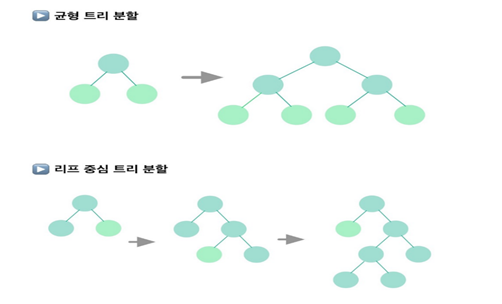

**캣부스트의 한계 :**
1. 결측치가 매우 많은 데이터셋에는 부적합하다.
2. 수치형 변수가 많으면 LightGBM보다 속도가 느려진다.

**Catboost는 기본 파라미터가 최적화가 잘 되어 있어 굳이 파라미터를 설정하지 않아도 됩니다.**

In [ ]:
# Catboost
#!pip install catboost

In [ ]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = seed)
folds = []
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
# cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
cat_cols = test.columns.tolist() 

for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data = X_train, label = y_train, cat_features = cat_cols)
  valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set = valid_data, use_best_model = True, early_stopping_rounds = 100, verbose = 100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------



Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.115128
0:	learn: 1.0350404	test: 1.0332919	best: 1.0332919 (0)	total: 347ms	remaining: 5m 47s
100:	learn: 0.7084332	test: 0.6618283	best: 0.6617103 (94)	total: 48.9s	remaining: 7m 14s
200:	learn: 0.6907119	test: 0.6587348	best: 0.6586775 (198)	total: 1m 37s	remaining: 6m 26s
300:	learn: 0.6729882	test: 0.6582358	best: 0.6576735 (280)	total: 2m 25s	remaining: 5m 37s
400:	learn: 0.6565367	test: 0.6585329	best: 0.6573444 (346)	total: 3m 13s	remaining: 4m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6573443743
bestIteration = 346

Shrink model to first 347 iterations.
CV Log Loss Score: 0.657344

----------------- Fold 1 -----------------

Learning rate set to 0.115128
0:	learn: 1.0348910	test: 1.0340173	best: 1.0340173 (0)	total: 212ms	remaining: 3m 32s
100:	learn: 0.7100184	test: 0.6623309	best: 0.6623309 (100)	total: 45.1s	remaining: 6m 41s
200:	learn: 0.6909764	test: 0.6597342	best: 0.6593238 (152)	total: 1m 32s	remaining: 6m 6s
300:	l

### Feature Importance

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_names' : feature_names, 'feature_importance' : feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by = ['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

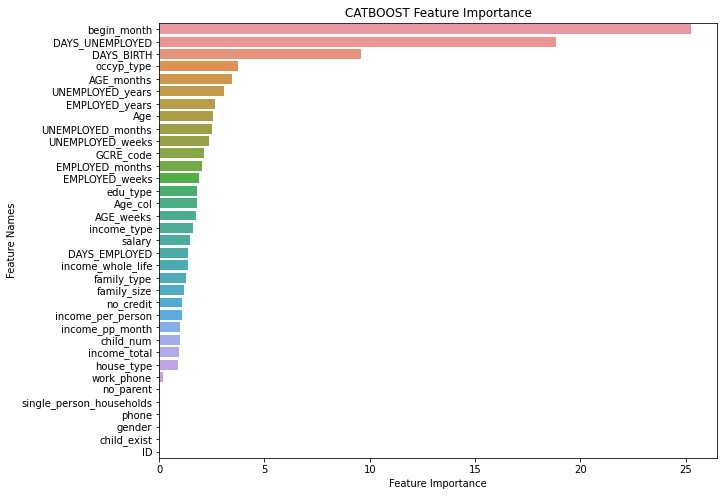

In [ ]:
plot_feature_importance(model_cat.get_feature_importance() , X_test.columns , 'CATBOOST')

## Submission

### submission 파일 불러오기

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

### submission 파일 저장

In [ ]:
sub.iloc[ : , 1: ] = cat_pred_test
sub

,index,0,1,2
0,26457,0.136494,0.177279,0.686227
1,26458,0.213073,0.170250,0.616677
2,26459,0.107568,0.142716,0.749716
3,26460,0.128218,0.240854,0.630928
4,26461,0.187233,0.216001,0.596766
...,...,...,...,...
9995,36452,0.143388,0.224068,0.632545
9996,36453,0.168375,0.224687,0.606938
9997,36454,0.136259,0.165297,0.698445
9998,36455,0.163823,0.172919,0.663258


In [ ]:
sub.to_csv('submission0130_2.csv', index = False)

# 그 외에 다른 시도들... 

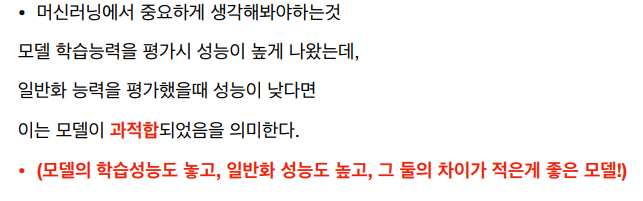

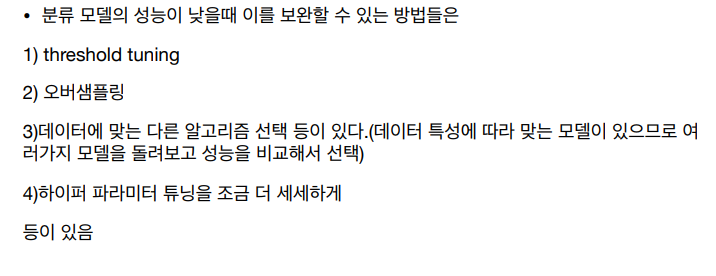